<a href="https://colab.research.google.com/github/tariqmhmd5/Covid-Prediction/blob/master/Prediction%20using%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
print(tf.__version__)

Using TensorFlow backend.


2.2.0


22/01/2020-today world data

30/01/2020-today india data

## Data Prepration for India
Data is imported from John Hopkins GitHub Repo and can be used for more analysis

In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])

full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})

df_india=full_df[full_df['Country']=='India']

world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(-1)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed']
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed']
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed']
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(-1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate']
    return df

In [0]:
world_df = add_rates(world_df)
df_india=add_rates(df_india)
df_india.reset_index(inplace=True,drop=True)
df_india=df_india[8:]
df_india.reset_index(inplace=True,drop=True)

In [22]:
df_india.head()

,Country,Province/State,Lat,Long,Date,Confirmed,Recoveries,Deaths,Confirmed Change,Mortality Rate,Recovery Rate,Growth Rate,Growth Rate Change,Growth Rate Accel
0,India,NaN,21.0,78.0,2020-01-30,1,0,0,0.0,0.0,0.0,0.0,0.0,NaN
1,India,NaN,21.0,78.0,2020-01-31,1,0,0,0.0,0.0,0.0,0.0,1.0,inf
2,India,NaN,21.0,78.0,2020-02-01,1,0,0,1.0,0.0,0.0,1.0,-0.5,-0.5
3,India,NaN,21.0,78.0,2020-02-02,2,0,0,1.0,0.0,0.0,0.5,-0.5,-1.0
4,India,NaN,21.0,78.0,2020-02-03,3,0,0,0.0,0.0,0.0,0.0,0.0,NaN


In [28]:
px.scatter(df_india,x='Date',y='Confirmed',title='Confirmed Cases in India')

In [29]:
px.scatter(world_df,x='Date',y='Confirmed',title='Confirmed Cases in World')

In [30]:
px.scatter(df_india,x='Date',y='Deaths',title='Deaths Cases in India')

In [31]:
px.scatter(world_df,x='Date',y='Deaths',title='Deaths Cases in World')

In [32]:
px.scatter(df_india,x='Date',y='Recoveries',title='Recover Cases in India')

In [33]:
px.scatter(world_df,x='Date',y='Recoveries',title='Recover Cases in World')

In [35]:
px.line(df_india,x='Date',y='Mortality Rate',title='Mortality Rate in India')

In [36]:
px.line(world_df,x='Date',y='Mortality Rate',title='Mortality Rate in World')

In [0]:
fig = make_subplots(rows=4,cols=2,
                    print_grid=True,column_titles=['India','World'],
    row_titles=['Confirmed','Deaths','Recoveries','Mortality'])

fig.append_trace(go.Line(
    x=df_india['Date'],
    y=df_india['Confirmed'], name='India Total Cases'
), row=1, col=1)

fig.append_trace(go.Line(
    x=world_df['Date'],
    y=world_df['Confirmed'], name='World Total Cases'
), row=1, col=2 )

fig.append_trace(go.Line( 
    x=df_india['Date'],
    y=df_india['Deaths'], name='India Total Deaths'
), row=2, col=1)

fig.append_trace(go.Line( 
    x=world_df['Date'],
    y=world_df['Deaths'], name='World Total Deaths'
), row=2, col=2)

fig.append_trace(go.Line( 
    x=df_india['Date'],
    y=df_india['Recoveries'], name='India Total Recoveries'
), row=3, col=1)

fig.append_trace(go.Line( 
    x=world_df['Date'],
    y=world_df['Recoveries'], name='World Total Recoveries'
), row=3, col=2)

fig.append_trace(go.Line( 
    x=df_india['Date'],
    y=df_india['Mortality Rate'], name='Inida Mortality Rate'
), row=4, col=1)

fig.append_trace(go.Line( 
    x=world_df['Date'],
    y=world_df['Mortality Rate'], name='World Mortality Rate'
), row=4, col=2)

#fig.update_layout(height=900, width=800, title_text="Stacked Subplots")
fig.show()

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



In [0]:
df=pd.DataFrame(df_india['Confirmed'])
#df=df[8:]
df.reset_index(inplace=True,drop=True)

In [0]:
df

,Confirmed
0,1
1,1
2,1
3,2
4,3
...,...
127,236184
128,246622
129,257486
130,265928


In [0]:
data=df['Confirmed'].values

### Scaling the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data.reshape(-1,1))

### Data generation to feed LSTM
creating the batches of data, 1 batch of training data contain 20 values and tagret to predict the last value in batch. 

In [0]:
X_Train = []
Y_Train = []

for i in range(20, Train.shape[0]):
    
    X_Train.append(Train[i-20:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(112, 20)
(112,)


### Spliting the data into training and testing
slicing the last 10 data batches for testing purpose 

In [0]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [0]:
X_Train.shape

(112, 20, 1)

In [0]:
X_test=X_Train[-10:,:,:]
y_test=Y_Train[-10:]
X_train=X_Train[0:-10,:,:]
Y_train=Y_Train[0:-10]

In [0]:
print(X_train.shape,Y_train.shape,X_test.shape,y_test.shape)

(102, 20, 1) (102,) (10, 20, 1) (10,)


## Simple LSTM Model

In [0]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_Train.shape[1], 1)))

regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [0]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
regressor.fit(X_Train, Y_Train, epochs = 100, batch_size = 4)

Epoch 1/100
112/112 [==============================] - 3s 25ms/step - loss: 0.0279
Epoch 2/100
112/112 [==============================] - 1s 8ms/step - loss: 8.7446e-04
Epoch 3/100
112/112 [==============================] - 1s 8ms/step - loss: 4.7361e-04
Epoch 4/100
112/112 [==============================] - 1s 8ms/step - loss: 2.5361e-04
Epoch 5/100
112/112 [==============================] - 1s 8ms/step - loss: 2.1401e-04
Epoch 6/100
112/112 [==============================] - 1s 8ms/step - loss: 9.1403e-05
Epoch 7/100
112/112 [==============================] - 1s 8ms/step - loss: 5.6968e-05
Epoch 8/100
112/112 [==============================] - 1s 8ms/step - loss: 5.1377e-05
Epoch 9/100
112/112 [==============================] - 1s 8ms/step - loss: 2.9012e-05
Epoch 10/100
112/112 [==============================] - 1s 8ms/step - loss: 3.1549e-05
Epoch 11/100
112/112 [==============================] - 1s 8ms/step - loss: 4.5179e-05
Epoch 12/100
112/112 [==============================] -

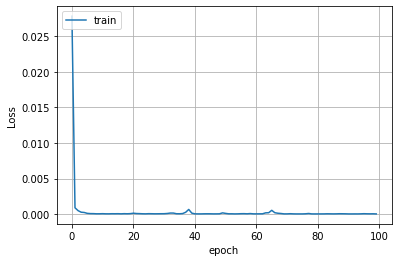

In [0]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [0]:
y_pred=sc.inverse_transform(regressor.predict(X_test))

In [0]:
y_pred

array([[189945.5 ],
       [198341.83],
       [207007.4 ],
       [215917.81],
       [225136.4 ],
       [234728.33],
       [244643.5 ],
       [254870.12],
       [265442.06],
       [276121.9 ]], dtype=float32)

In [0]:
y_test=sc.inverse_transform(y_test.reshape(-1,1))

In [0]:
y_test

array([[190609.],
       [198370.],
       [207191.],
       [216824.],
       [226713.],
       [236184.],
       [246622.],
       [257486.],
       [265928.],
       [276146.]])

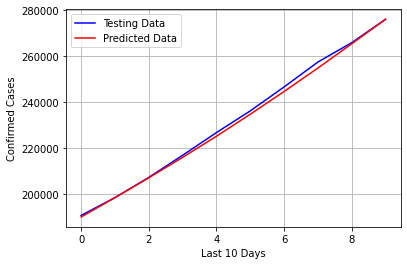

In [0]:
plt.figure()
plt.plot(y_test,label="Testing Data",c="b")
plt.plot(y_pred,label="Predicted Data",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("Last 10 Days")
plt.legend()
plt.grid()
plt.show()

#### Now training the model on full data and forcasting the cases

In [0]:
data=df['Confirmed'].values

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data.reshape(-1,1))

In [0]:
X_Train = []
Y_Train = []

for i in range(20, Train.shape[0]):
    
    X_Train.append(Train[i-20:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(112, 20)
(112,)


In [0]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [0]:
print(X_Train.shape,Y_Train.shape)

(112, 20, 1) (112,)


In [0]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_Train.shape[1], 1)))

regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [0]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 4)

Epoch 1/30
112/112 [==============================] - 1s 10ms/step - loss: 0.0089
Epoch 2/30
112/112 [==============================] - 1s 8ms/step - loss: 8.1750e-04
Epoch 3/30
112/112 [==============================] - 1s 8ms/step - loss: 1.8546e-04
Epoch 4/30
112/112 [==============================] - 1s 8ms/step - loss: 1.0789e-04
Epoch 5/30
112/112 [==============================] - 1s 8ms/step - loss: 5.6535e-05
Epoch 6/30
112/112 [==============================] - 1s 8ms/step - loss: 4.1417e-05
Epoch 7/30
112/112 [==============================] - 1s 8ms/step - loss: 3.3819e-05
Epoch 8/30
112/112 [==============================] - 1s 9ms/step - loss: 2.9215e-05
Epoch 9/30
112/112 [==============================] - 1s 8ms/step - loss: 2.4753e-05
Epoch 10/30
112/112 [==============================] - 1s 8ms/step - loss: 3.3822e-05
Epoch 11/30
112/112 [==============================] - 1s 8ms/step - loss: 2.7953e-05
Epoch 12/30
112/112 [==============================] - 1s 8ms/step

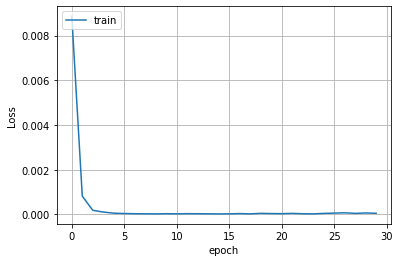

In [0]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [0]:
pred=[]
for i in X_Train[-1]:
    pred.append(i)

## Here predicting the future with sliding window concept
every time top value form batch is poped and model will predict a value which appended to the batch for next prediction

In [0]:
pred.append(regressor.predict(X_Train[-1].reshape(1,20,1)))

In [0]:
forcast=[]
for i in range(60):
    pred.reverse()
    pred.pop()
    pred.reverse()
    forcast.append(sc.inverse_transform(regressor.predict(np.array(pred).reshape(1,20,1))))
    pred.append(regressor.predict(np.array(pred).reshape(1,20,1))) 

In [0]:
future=[]
for i in forcast:
    future.append(i.flatten())

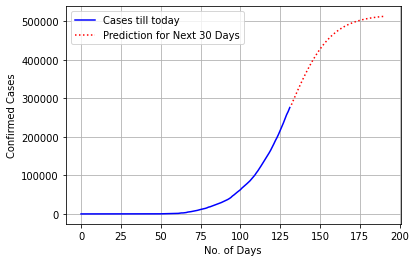

In [0]:
plt.figure()
plt.plot(sc.inverse_transform(Train),label="Cases till today",c="b")
plt.plot(pd.DataFrame(future,index=range(len(Train),len(Train)+60),columns=['Predicted']),label="Prediction for Next 30 Days",c="r",linestyle='dotted')
plt.ylabel("Confirmed Cases")
plt.xlabel("No. of Days")
plt.legend()
plt.grid()
plt.show()